In [338]:
base_dir = '../../../../1.YL/HWs/Required-files-for-projects/Datasets/2.PEOPLE/filtered'  # Directory containing class folders
target_count = 1000  # Target number of images per class

In [339]:
import os
import random, numpy as np
import cv2
import tensorflow as tf
import imghdr

from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import LeakyReLU
from keras import optimizers

### Create Augmented Images

In [340]:
def rotate_image(image_path, degrees):
    """Rotate the image by a specific degree and return it."""
    try:
        with Image.open(image_path) as img:
            rotated = img.rotate(degrees, expand=True, fillcolor=tuple(np.mean(np.array(img)[0,:], axis=0).astype(int)))
            # rotated = img.rotate(degrees, expand=True)
            return rotated
    except Exception as e:
        print(f"Error rotating image {image_path}: {e}")
        return None

def augment_images(input_dir, output_dir, target_count):
    """Augment images in the input directory to reach the target count, saving them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = [f for f in os.listdir(input_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)
    augment_count = target_count - current_count

    print(f"Class {os.path.basename(input_dir)} - Current count: {current_count}, Augmenting {augment_count} images to reach {target_count}.")

    for i in range(augment_count):
        img_name = random.choice(images)
        img_path = os.path.join(input_dir, img_name)
        degrees = random.uniform(0, 360)  # Random rotation degree between 0 and 360

        rotated_img = rotate_image(img_path, degrees)
        if rotated_img is not None:
            # Convert image to RGB if it's in RGBA or P mode
            if rotated_img.mode in ['RGBA', 'P']:
                rotated_img = rotated_img.convert('RGB')
            new_img_name = f"{os.path.splitext(img_name)[0]}_rotated_{i}.jpg"
            rotated_img.save(os.path.join(output_dir, new_img_name))

def create_augmented_images():
    for class_name in os.listdir(base_dir):
        input_class_dir = os.path.join(base_dir, class_name)
        output_class_dir = os.path.join(base_dir, class_name + '_augmented')

        if os.path.isdir(input_class_dir):
            augment_images(input_class_dir, output_class_dir, target_count)

# create_augmented_images()

### Dirty Image Cleaner

In [341]:
def dirty_image_cleaner():
    image_exts = ['jpeg','jpg', 'bmp', 'png']
    for image_class in os.listdir(base_dir): 
        for image in os.listdir(os.path.join(base_dir, image_class)):
            image_path = os.path.join(base_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
            
# dirty_image_cleaner()

### Get Data

In [342]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)

Found 5915 files belonging to 6 classes.


In [343]:
tf.config.list_physical_devices('GPU') 

[]

In [344]:
class_names = data.class_names

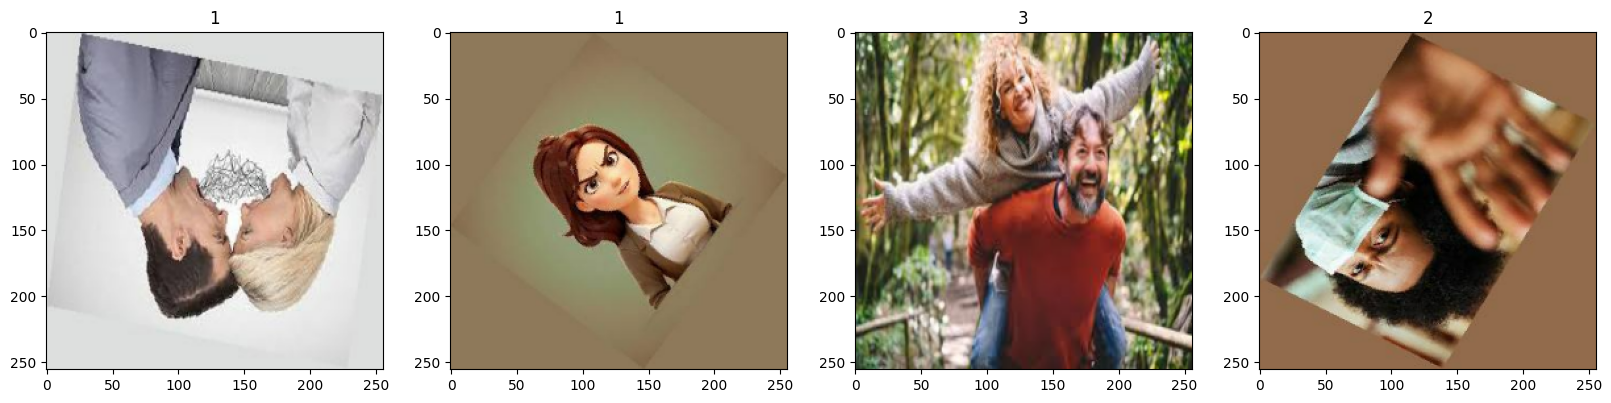

In [345]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [346]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          ...,
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ]],
 
         [[0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          ...,
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ]],
 
         [[0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          ...,
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ],
          [0.6431373 , 0.64705884, 0.627451  ]],
 
         ...,
 
         [[0.6431373 , 0.64705884, 0.627451  ],
          [0.64313

In [347]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [348]:
train_size

129

In [349]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [350]:
model = Sequential()

In [351]:
#Model1
# model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D())
# 
# model.add(Conv2D(32, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D())
# 
# model.add(Conv2D(16, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D())
# 
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [352]:
#Model2
# model.add(Conv2D(16, (3,3), padding='valid', input_shape=(256,256,3)))
# model.add(LeakyReLU(alpha=0.02))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# 
# model.add(Conv2D(32, (3,3), padding='valid'))
# model.add(LeakyReLU(alpha=0.02))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# 
# model.add(Conv2D(16, (3,3), padding='valid'))
# model.add(LeakyReLU(alpha=0.02))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# 
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(6, activation='softmax'))

In [353]:
# Model3+
# model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
# 
# model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
# 
# model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
# 
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [354]:
#Model4
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [355]:
# Model5
model.add(Conv2D(16, (3, 3), strides=1, input_shape=(256, 256, 3)))
model.add(LeakyReLU(alpha=0.02))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), strides=1))
model.add(LeakyReLU(alpha=0.02))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), strides=1))
model.add(LeakyReLU(alpha=0.02))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.02))
model.add(Dense(6, activation='softmax'))

/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/mehmet-ercan/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [356]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,910 (14.11 MB)

 Trainable params: 3,697,910 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

In [357]:
hist = model.fit(train, epochs=9, validation_data=val)

Epoch 1/9


2024-06-13 17:46:32.951034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_16_1/leaky_re_lu_31_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_16_1/conv2d_51_1/add'.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.1737 - loss: 2.9210

2024-06-13 17:47:11.430137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.1739 - loss: 2.9144 - val_accuracy: 0.1909 - val_loss: 1.8573
Epoch 2/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2799 - loss: 1.7057

2024-06-13 17:47:49.518250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - accuracy: 0.2800 - loss: 1.7055 - val_accuracy: 0.2593 - val_loss: 1.7847
Epoch 3/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3516 - loss: 1.5723

2024-06-13 17:48:28.308024: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.3516 - loss: 1.5723 - val_accuracy: 0.3066 - val_loss: 1.7014
Epoch 4/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4153 - loss: 1.4750

2024-06-13 17:49:05.012912: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.4153 - loss: 1.4749 - val_accuracy: 0.3218 - val_loss: 1.6886
Epoch 5/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4542 - loss: 1.3721

2024-06-13 17:49:41.707143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.4542 - loss: 1.3722 - val_accuracy: 0.4029 - val_loss: 1.5398
Epoch 6/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5023 - loss: 1.2775

2024-06-13 17:50:18.689110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 286ms/step - accuracy: 0.5022 - loss: 1.2776 - val_accuracy: 0.4096 - val_loss: 1.5086
Epoch 7/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5677 - loss: 1.1518

2024-06-13 17:50:57.406678: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.5676 - loss: 1.1519 - val_accuracy: 0.3834 - val_loss: 1.5900
Epoch 8/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5991 - loss: 1.0668

2024-06-13 17:51:36.865711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.5991 - loss: 1.0669 - val_accuracy: 0.4417 - val_loss: 1.4903
Epoch 9/9
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6619 - loss: 0.9496

2024-06-13 17:52:18.110858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.6618 - loss: 0.9497 - val_accuracy: 0.4443 - val_loss: 1.5240


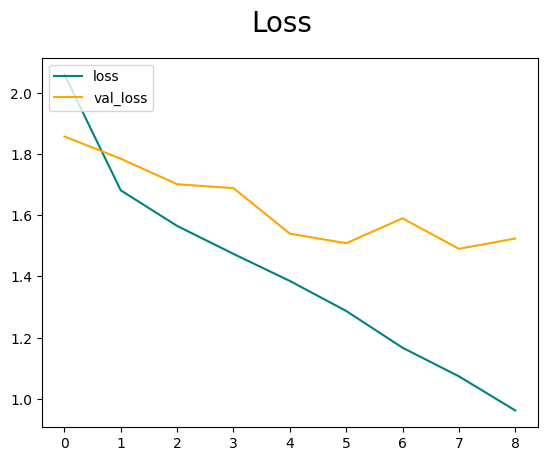

In [358]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

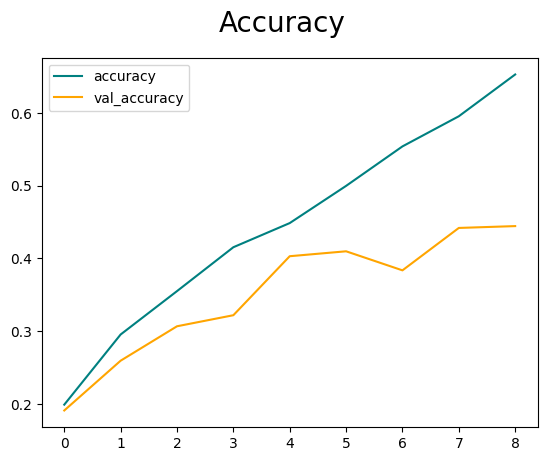

In [359]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

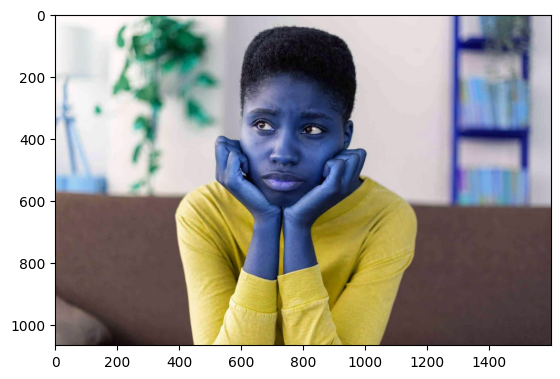

In [360]:
img = cv2.imread('img.png')
plt.imshow(img)
plt.show()

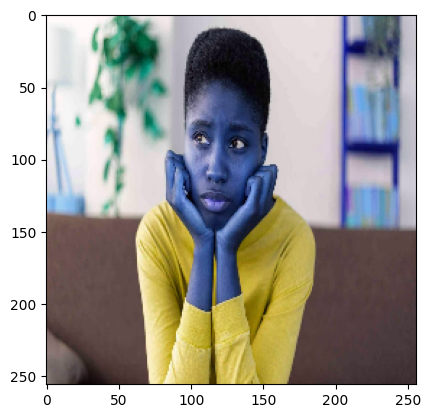

In [361]:
resized_image = tf.image.resize(img, (256,256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [362]:
pred = model.predict(np.expand_dims(resized_image/255, 0))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[3.2944297e-03, 2.8696582e-01, 4.7089434e-05, 3.0278094e-02,
        6.7815655e-01, 1.2580372e-03]], dtype=float32)

In [363]:
class_names[np.argmax(pred)]

'sad'

### Save the Model

In [364]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imageclassifier.keras'))

In [365]:
np.random.rand(1,10)

array([[0.60389723, 0.89169589, 0.65708814, 0.91754635, 0.20520544,
        0.60484297, 0.60633753, 0.95302982, 0.19071467, 0.17284055]])

In [366]:
new_model = load_model('models/imageclassifier.keras')

In [367]:
results = new_model.predict(np.expand_dims(resized_image/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [368]:
class_names[np.argmax(results)]

'sad'